In [1]:
import pyrost as rst
import pyrost.simulation as st_sim
import numpy as np
import matplotlib.pyplot as plt
import os

# Performing a multislice beam propagation

In [3]:
import pyrost.multislice as ms_sim
params = ms_sim.MSParams.import_default()
params = params.replace(x_step=5e-5, z_step=5e-3, n_min=100, n_max=5000,
                        focus=1.5e3, mll_sigma=5e-5, mll_wl=6.2e-5, wl=6.2e-5,
                        x_max=30.0, mll_depth=5.0)

In [5]:
mll = ms_sim.MLL.import_params(params)

In [6]:
ms_prgt = ms_sim.MSPropagator(params, mll)
ms_prgt.beam_propagate()

   0%            Slice 0 / 999 [00:00<?, ?it/s]

In [7]:
z_arr = np.linspace(0.2 * params.focus, 2.0 * params.focus, 300)
ds_beam, x_arr = ms_prgt.beam_downstream(z_arr, step=4.0 * params.x_step)

  0%|          | 0/300 [00:00<?, ?it/s]

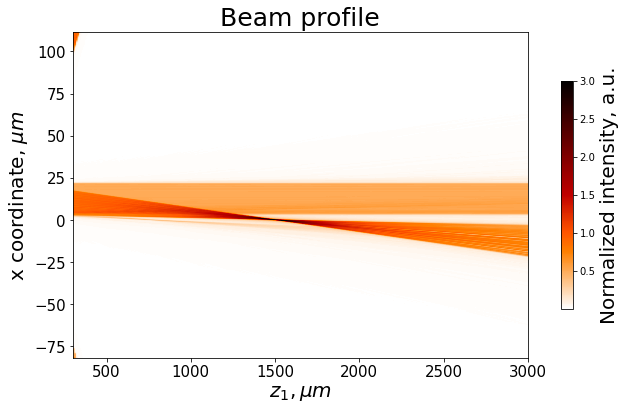

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im1 = ax.imshow(np.abs(ds_beam[::10]), vmax=3., cmap='gist_heat_r',
                extent=[z_arr.min(), z_arr.max(), x_arr.min(), x_arr.max()])
cbar = fig.colorbar(im1, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('Normalized intensity, a.u.', fontsize=20)
ax.set_ylabel(r'x coordinate, $\mu m$', fontsize=20)
ax.set_aspect(10)
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
ax.set_title('Beam profile', fontsize=25)
plt.show()

# Speckle tracking reconstruction of a 2d dataset

In [ ]:
# OS X
!mkdir -p results/exp
!curl https://www.cxidb.org/data/134/diatom.cxi -o results/exp/diatom.cxi

In [2]:
# Linux
!wget -P results/exp "https://www.cxidb.org/data/134/diatom.cxi"

--2022-02-24 15:38:14--  https://www.cxidb.org/data/134/diatom.cxi
Resolving www.cxidb.org (www.cxidb.org)... 104.21.9.67, 172.67.159.52, 2606:4700:3033::6815:943, ...
Connecting to www.cxidb.org (www.cxidb.org)|104.21.9.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97269404 (93M) [application/octet-stream]
Saving to: ‘results/exp/diatom.cxi.1’

 9% [==>                                    ] 8,838,911   --.-K/s  eta 10m 0s  ^C


In [2]:
!h5ls -r results/exp/diatom.cxi

/                        Group
/entry_1                 Group
/entry_1/data_1          Group
/entry_1/data_1/data     Dataset {121, 516, 1556}
/entry_1/data_1/experiment_identifier Dataset {121}
/entry_1/end_time        Dataset {SCALAR}
/entry_1/experiment_identifier Dataset, same as /entry_1/data_1/experiment_identifier
/entry_1/instrument_1    Group
/entry_1/instrument_1/detector_1 Group
/entry_1/instrument_1/detector_1/basis_vectors Dataset {121, 2, 3}
/entry_1/instrument_1/detector_1/corner_positions Dataset {121, 3}
/entry_1/instrument_1/detector_1/count_time Dataset {121, 1}
/entry_1/instrument_1/detector_1/data Dataset, same as /entry_1/data_1/data
/entry_1/instrument_1/detector_1/distance Dataset {SCALAR}
/entry_1/instrument_1/detector_1/experiment_identifier Dataset, same as /entry_1/data_1/experiment_identifier
/entry_1/instrument_1/detector_1/mask Dataset {516, 1556}
/entry_1/instrument_1/detector_1/name Dataset {SCALAR}
/entry_1/instrument_1/detector_1/x_pixel_size Dataset 

In [2]:
protocol = rst.CXIProtocol.import_default()

In [3]:
inp_file = rst.CXIStore('results/exp/diatom.cxi', protocol=protocol)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


In [4]:
out_file = rst.CXIStore('results/exp/diatom_proc.cxi', mode='a',
                        protocol=protocol)

In [5]:
data = rst.STData(input_file=inp_file, output_file=out_file)

In [6]:
inp_file.keys()

dict_keys(['basis_vectors', 'data', 'distance', 'translations', 'wavelength', 'x_pixel_size', 'y_pixel_size'])

In [7]:
data = data.load(processes=4)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


Loading data:   0%|          | 0/121 [00:00<?, ?it/s]

In [8]:
crop = rst.Crop(roi=[80, 420, 60, 450])
data = data.update_transform(transform=crop)

In [9]:
data = data.update_mask(method='range-bad', vmax=2e3)
data = data.mask_frames(frames=np.arange(1, 121))

In [10]:
defoci = np.linspace(2e-3, 3e-3, 50)
sweep_scan = data.defocus_sweep(defoci, size=5, hval=1.5)
defocus = defoci[np.argmax(sweep_scan)]
print(defocus)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

0.002204081632653061


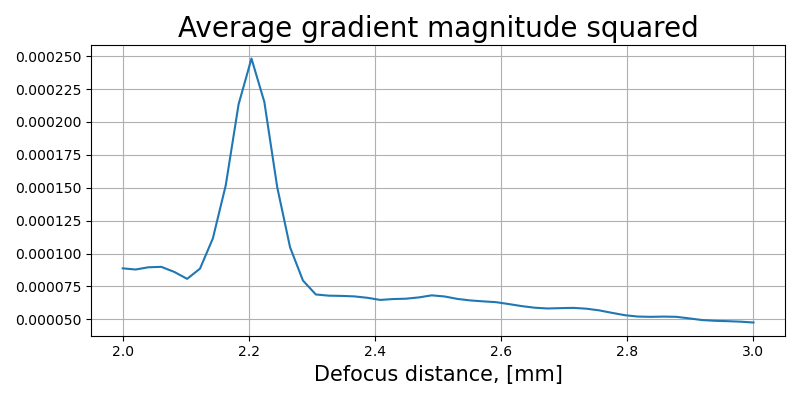

In [11]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(defoci * 1e3, sweep_scan)
ax.set_xlabel('Defocus distance, [mm]', fontsize=15)
ax.set_title('Average gradient magnitude squared', fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sweep_scan.png', dpi=300)

In [10]:
data = data.update_defocus(defocus)
# data = data.update_defocus(0.002204081632653061)

In [11]:
st_obj = data.get_st(ds_x=3.0, ds_y=3.0)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


In [12]:
h_vals = np.linspace(0.5, 3.0, 25)
cv_vals = st_obj.CV_curve(h_vals)

Calculating CV:   0%|          | 0/25 [00:00<?, ?it/s]

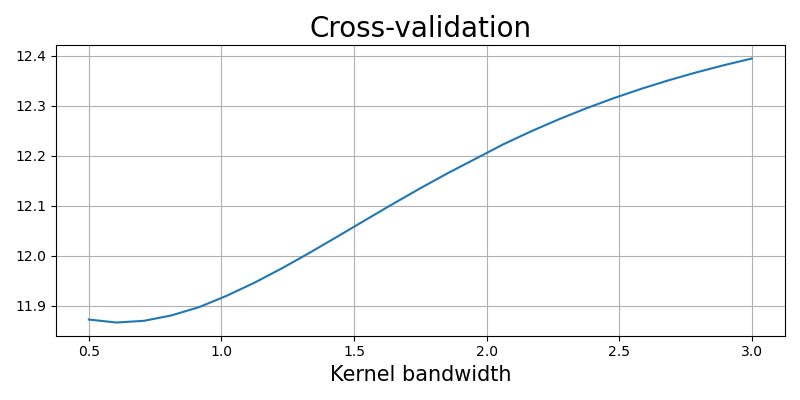

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(h_vals, cv_vals)
ax.set_xlabel('Kernel bandwidth', fontsize=15)
ax.set_title('Cross-validation', fontsize=20)
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/cv_curve.png', dpi=300)

In [18]:
st_obj = data.get_st(ds_x=3.0, ds_y=3.0)
st_obj = st_obj.create_initial()
h0 = st_obj.find_hopt(verbose=True)
print(h0)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)
mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


   0%            Iteration 0 / 10 [00:00<?, ?it/s]

0.6298771496611755


In [13]:
st_obj = st_obj.update_reference(hval=0.7)

In [56]:
st_res = st_obj.train_adapt(search_window=(2.0, 2.0, 0.1), h0=h0, blur=16.0, n_iter=10,
                            pm_method='rsearch', pm_args={'n_trials': 50, 'strides': (4, 4)},
                            options={'momentum': 0.3})

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.930730, Initial h0 = 0.63


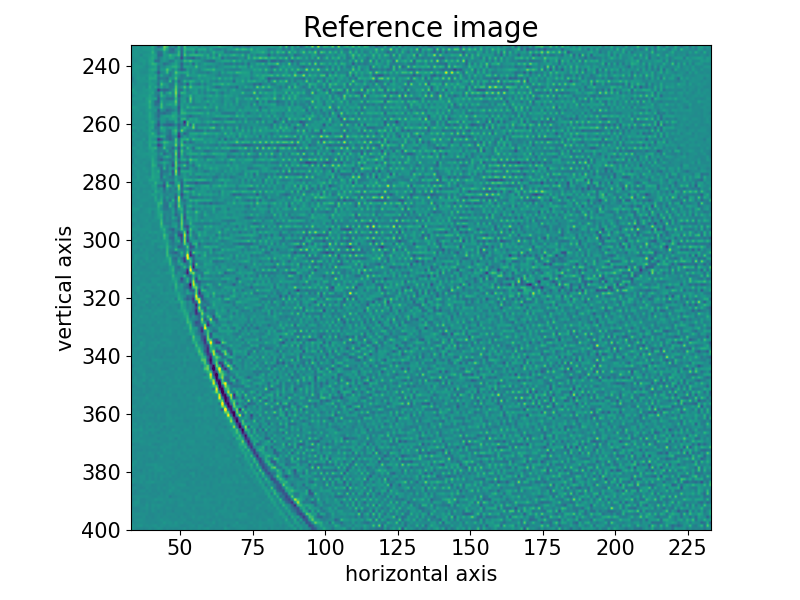

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(st_res.reference_image[233:400, 33:233], vmin=0.7, vmax=1.3,
          extent=[33, 233, 400, 233])
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_image.png', dpi=150)

In [52]:
data.import_st(st_res)
fit_obj_ss = data.get_fit(axis=0)
fit_ss = fit_obj_ss.fit(max_order=3)
fit_obj_fs = data.get_fit(axis=1)
fit_fs = fit_obj_fs.fit(max_order=3)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


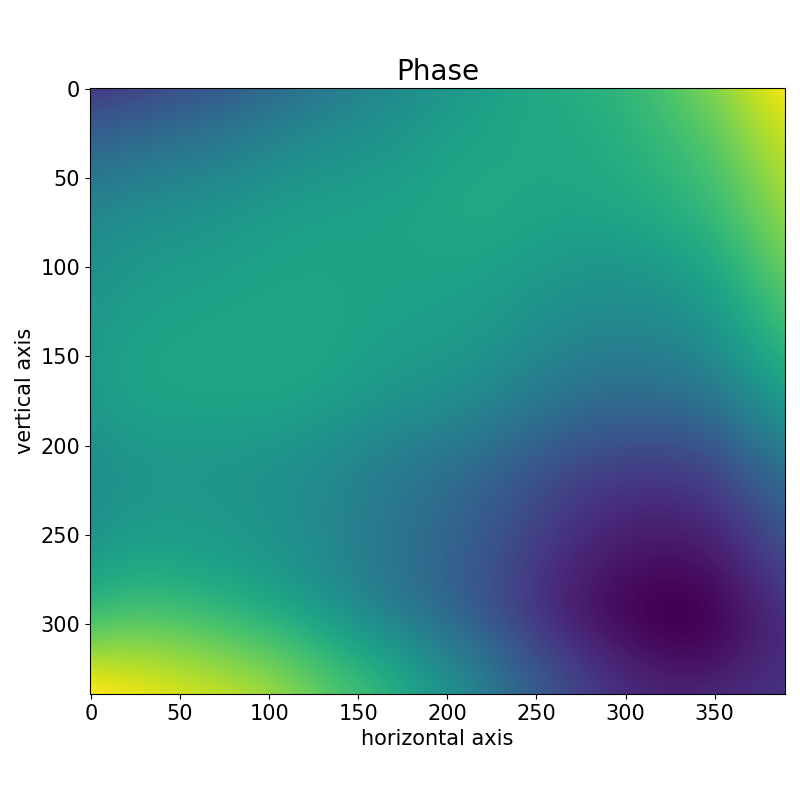

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_phase.png', dpi=150)

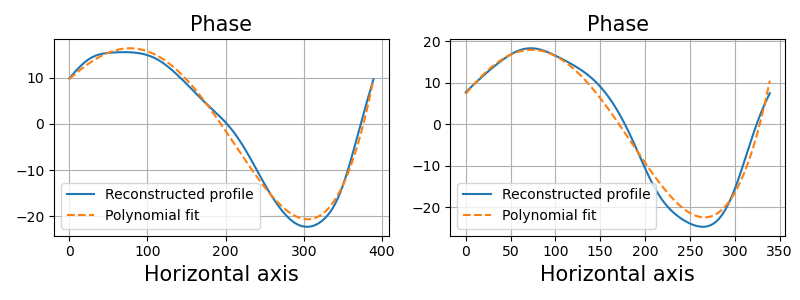

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.phase, label='Reconstructed profile')
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.model(fit_fs['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[0].set_xlabel('Horizontal axis', fontsize=15)
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.phase, label='Reconstructed profile')
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.model(fit_ss['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[1].set_xlabel('Horizontal axis', fontsize=15)
for ax in axes:
    ax.set_title('Phase', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/phase_fit.png', dpi=300)

In [32]:
data.save(mode='overwrite')

In [33]:
!h5ls -r results/exp/diatom_proc.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {120/Inf, 340, 390}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {1}
/entry/instrument/detector/x_pixel_size Dataset {1}
/entry/instrument/detector/y_pixel_size Dataset {1}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {1}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {120/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {120/Inf, 340, 390}
/speckle_tracking/phase  Dataset {340, 390}
/speckle_tracking/pixel_aberrations Dataset {2, 340, 390}
/speckle_tracking/pixel_translations Dataset {120/Inf, 2}
/speckle_tracking/reference_image Dataset {481, 492}
/speckle_tracking/scale_map Dataset {340, 390}
/speckle_tracking/translations Dataset {120/Inf, 3}
/speckle_tracking

# Generating a speckle tracking dataset

In [2]:
params = st_sim.STParams.import_default()
params = params.replace(bar_size=0.7, bar_sigma=0.12, bar_atn=0.18,
                        bulk_atn=0.2, p0=5e4, th_s=8e-5, n_frames=100,
                        offset=2.0, step_size=0.1, defocus=150, alpha=0.05,
                        ab_cnt=0.7, bar_rnd=0.8)

In [3]:
protocol = rst.CXIProtocol.import_default()

In [3]:
sim_obj = st_sim.STSim(params)
ptych = sim_obj.ptychograph()
st_conv = st_sim.STConverter(sim_obj, ptych)
st_conv.save('results/sim.cxi', mode='overwrite')

In [13]:
!rm -rf results/sim.cxi

In [4]:
!h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {100/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {100/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {100/Inf, 1, 985}
/speckle_tracking/pixel_translations Dataset {100/Inf, 2}
/speckle_tracking/translations Dataset {100/Inf, 3}
/speckle_tracking/whitefield Dataset {1, 985}


In [5]:
sim_obj = st_sim.STSim(params)
ptych = sim_obj.ptychograph()
st_conv = st_sim.STConverter(sim_obj, ptych)
data = st_conv.export_data('results/sim.cxi')
data = data.load()

Loading data:   0%|          | 0/100 [00:00<?, ?it/s]

Loading mask:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
%%bash
source /software/anaconda3/5.2/bin/activate pyrost
python -m pyrost.simulation --help

usage: __main__.py [-h] [-f INI_FILE] [--defocus DEFOCUS]
                   [--det_dist DET_DIST] [--step_size STEP_SIZE]
                   [--step_rnd STEP_RND] [--n_frames N_FRAMES]
                   [--detx_size DETX_SIZE] [--dety_size DETY_SIZE] [--p0 P0]
                   [--wl WL] [--th_s TH_S] [--ap_x AP_X] [--ap_y AP_Y]
                   [--focus FOCUS] [--alpha ALPHA] [--ab_cnt AB_CNT]
                   [--bar_size BAR_SIZE] [--bar_sigma BAR_SIGMA]
                   [--bar_atn BAR_ATN] [--bulk_atn BULK_ATN]
                   [--bar_rnd BAR_RND] [--offset OFFSET] [-p]
                   out_path

Run Speckle Tracking simulation

positional arguments:
  out_path              Output folder path

optional arguments:
  -h, --help            show this help message and exit
  -f INI_FILE, --ini_file INI_FILE
                        Path to an INI file to fetch all of the simulation
                        parameters (default: None)
  --defocus DEFOCUS     Lens defocus distanc

In [2]:
%%bash
source /software/anaconda3/5.2/bin/activate pyrost
python -m pyrost.simulation results/sim.cxi --bar_size 0.7 --bar_sigma 0.12 \
    --bar_atn 0.18 --bulk_atn 0.2 --p0 5e4 --th_s 8e-5 --n_frames 200 --offset 2 \
    --step_size 0.1 --defocus 150 --alpha 0.05 --ab_cnt 0.7 --bar_rnd 0.8 -p

The simulation results have been saved to /gpfs/cfel/user/nivanov/speckle-tracking/pyrost/results/sim.cxi


In [3]:
!h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {200/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {200/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {200/Inf, 1, 985}
/speckle_tracking/pixel_translations Dataset {200/Inf, 2}
/speckle_tracking/translations Dataset {200/Inf, 3}
/speckle_tracking/whitefield Dataset {1, 985}


# Speckle tracking reconstruction of a simulated dataset

In [2]:
protocol = rst.CXIProtocol.import_default()
inp_file = rst.CXIStore('results/sim.cxi', protocol=protocol)
out_file = rst.CXIStore('results/sim.cxi', mode='a', protocol=protocol)
data = rst.STData(input_file=inp_file, output_file=out_file)
data = data.load()

Loading data:   0%|          | 0/200 [00:00<?, ?it/s]

Loading mask:   0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
data.contents()

['input_file',
 'basis_vectors',
 'data',
 'defocus_x',
 'defocus_y',
 'distance',
 'frames',
 'output_file',
 'phase',
 'pixel_aberrations',
 'reference_image',
 'scale_map',
 'translations',
 'wavelength',
 'x_pixel_size',
 'y_pixel_size',
 'good_frames',
 'mask',
 'num_threads',
 'pixel_translations',
 'whitefield']

In [4]:
st_obj = data.get_st()
h0 = st_obj.find_hopt()
st_res = st_obj.train_adapt(search_window=(0.0, 10.0, 0.1), h0=h0, blur=8.0)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial error = 12.241203, Initial h0 = 2.30


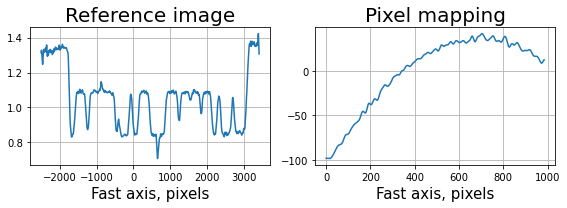

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(np.arange(st_res.reference_image.shape[1]) - st_res.ref_orig[1],
             st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=10)
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_res.png', dpi=300)

In [6]:
data.import_st(st_res)

In [7]:
fit_obj = data.get_fit(axis=1, center=20)
fit_obj = fit_obj.remove_linear_term()
fit = fit_obj.fit(max_order=2)
print(fit['c_3'])

[[-0.04679352]]


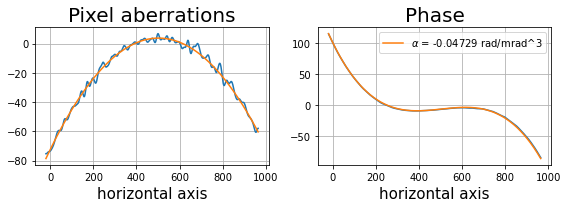

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_aberrations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']))
axes[0].set_title('Pixel aberrations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']),
             label=fr"$\alpha$ = {fit['c_3'][0]:.5f} rad/mrad^3")
axes[1].set_title('Phase', fontsize=20)
axes[1].legend(fontsize=10)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('horizontal axis', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png', dpi=300)

In [11]:
data.save(mode='overwrite')

In [12]:
! h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {200/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {1}
/entry/instrument/detector/x_pixel_size Dataset {1}
/entry/instrument/detector/y_pixel_size Dataset {1}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {1}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {200/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {1}
/speckle_tracking/defocus_y Dataset {1}
/speckle_tracking/mask   Dataset {200/Inf, 1, 985}
/speckle_tracking/phase  Dataset {1, 985}
/speckle_tracking/pixel_aberrations Dataset {2, 1, 985}
/speckle_tracking/pixel_translations Dataset {200/Inf, 2}
/speckle_tracking/reference_image Dataset {1, 5926}
/speckle_tracking/scale_map Dataset {1, 985}
/speckle_tracking/translations Dataset {200/Inf, 3}
/speckle_tracking/whitefield Dataset {

# Processing a wavefront metrology experiment

In [2]:
scan_num = 2989
log_path = f'/gpfs/cfel/group/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_num:d}.log'
data_dir = f'/gpfs/cfel/group/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_num:d}'
data_files = sorted([os.path.join(data_dir, path) for path in os.listdir(data_dir)
                     if path.endswith('Lambda.nxs')])
wl_dict = {'Mo': 7.092917530503447e-11,
           'Cu': 1.5498024804150033e-10,
           'Rh': 6.137831605603974e-11}

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/cfel/group/cxi/labs/MLL-Sigray/scan-frames/Scan_2989'

In [3]:
converter = rst.KamzikConverter()
converter = converter.read_logs(log_path)

In [10]:
rst.KamzikConverter()

KamzikConverter(protocol=LogProtocol(datatypes={'lens_down_dist': 'float', 'lens_up_dist': 'float', 'exposure': 'float', 'n_points': 'int', 'n_steps': 'int', 'scan_type': 'str', 'step_size': 'float', 'x_sample': 'float', 'y_sample': 'float', 'z_sample': 'float'}, log_keys={'lens_down_dist': ['Z-LENSE-DOWN_det_dist'], 'lens_up_dist': ['Z-LENSE-UP_det_dist'], 'exposure': ['Exposure'], 'n_points': ['Points count'], 'n_steps': ['Steps count'], 'scan_type': ['Device'], 'step_size': ['Step size'], 'x_sample': ['X-SAM', 'SAM-X', 'SCAN-X'], 'y_sample': ['Y-SAM', 'SAM-Y', 'SCAN-Y'], 'z_sample': ['Z-SAM', 'SAM-Z', 'SCAN-Z']}, part_keys={'lens_down_dist': 'Session logged attributes', 'lens_up_dist': 'Session logged attributes', 'exposure': 'Type: Method', 'n_points': 'Type: Scan', 'n_steps': 'Type: Scan', 'scan_type': 'Type: Scan', 'step_size': 'Type: Scan', 'x_sample': 'Session logged attributes', 'y_sample': 'Session logged attributes', 'z_sample': 'Session logged attributes'}), fs_vec=array([-

In [11]:
converter.cxi_keys()

['basis_vectors',
 'dist_down',
 'dist_up',
 'sim_translations',
 'log_translations']

In [12]:
log_data = converter.cxi_get(['basis_vectors', 'log_translations'])

In [13]:
input_file = rst.CXIStore(data_files)
data = rst.STData(input_file, **log_data, distance=2.0, wavelength=wl_dict['Mo'])

In [14]:
data.contents()

['input_file',
 'basis_vectors',
 'distance',
 'translations',
 'wavelength',
 'x_pixel_size',
 'y_pixel_size',
 'num_threads']

In [15]:
data = data.load('data')

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

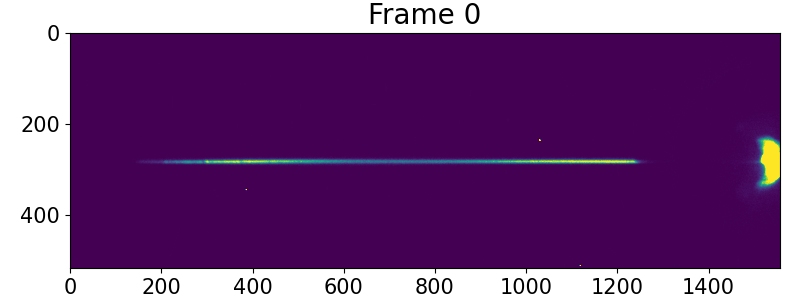

In [16]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(data.data[0], vmax=100)
ax.set_title('Frame 0', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_frame.png', dpi=150)

In [18]:
crop = rst.Crop([270, 300, 200, 1240])
mirror = rst.Mirror(axis=1, shape=(crop.roi[1] - crop.roi[0], crop.roi[3] - crop.roi[2]))
transform = rst.ComposeTransforms([crop, mirror])
data = data.update_transform(transform=transform)
data = data.update_mask(vmax=100000)

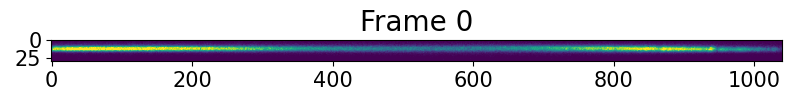

In [19]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(data.data[0], vmax=100)
ax.set_title('Frame 0', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_crop.png', dpi=150)

In [20]:
data = data.integrate_data()

In [21]:
data = data.mask_frames(np.arange(5, 100))

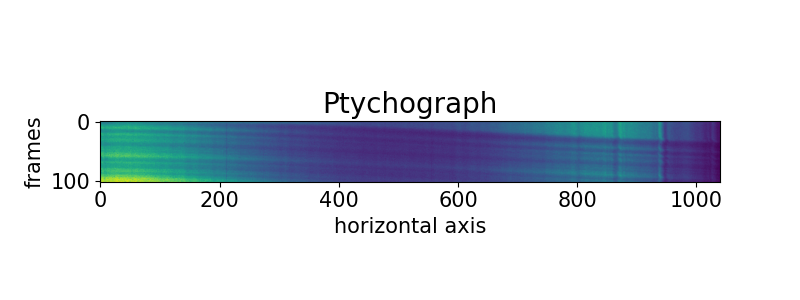

In [22]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(data.data[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('frames', fontsize=15)
ax.tick_params(labelsize=15)
plt.show()
# plt.savefig('docs/figures/sigray_ptychograph.png', dpi=150)

In [23]:
defoci = np.linspace(50e-6, 300e-6, 50)
sweep_scan = data.defocus_sweep(defoci, size=50)
defocus = defoci[np.argmax(sweep_scan)]
print(defocus)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

0.00015714285714285713


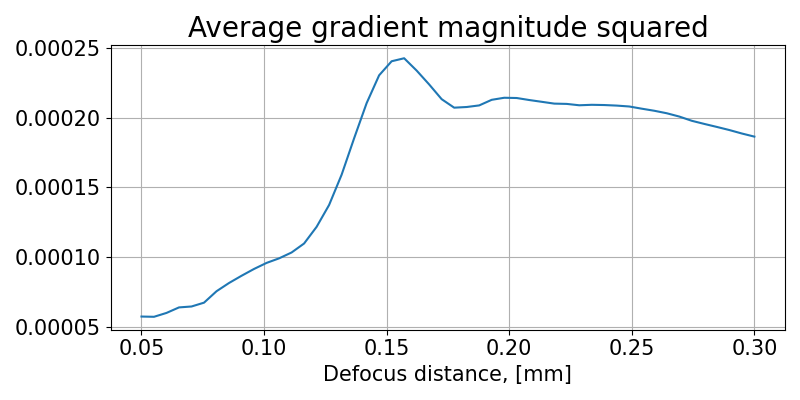

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(defoci * 1e3, sweep_scan)
ax.set_xlabel('Defocus distance, [mm]', fontsize=15)
ax.set_title('Average gradient magnitude squared', fontsize=20)
ax.tick_params(labelsize=15)
ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sweep_scan_sigray.png', dpi=300)

In [25]:
data = data.update_defocus(defocus)

In [26]:
st_obj = data.get_st()
h0 = st_obj.find_hopt()
st_res = st_obj.train_adapt(search_window=(0.0, 10.0, 0.1), h0=h0, blur=8.0)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial error = 52.725217, Initial h0 = 4.82


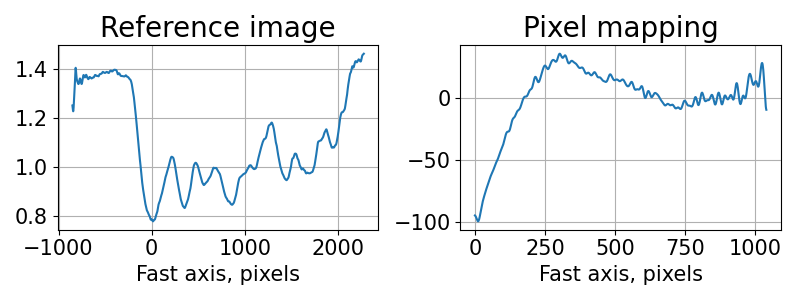

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(np.arange(st_res.reference_image.shape[1]) - st_res.ref_orig[1],
             st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_res.png', dpi=300)

In [28]:
data.import_st(st_res)

In [29]:
fit_obj = data.get_fit(axis=1)
fit_obj = fit_obj.remove_linear_term()
fit = fit_obj.fit(max_order=3)

In [30]:
fit['c_4']

0.004655967829994087

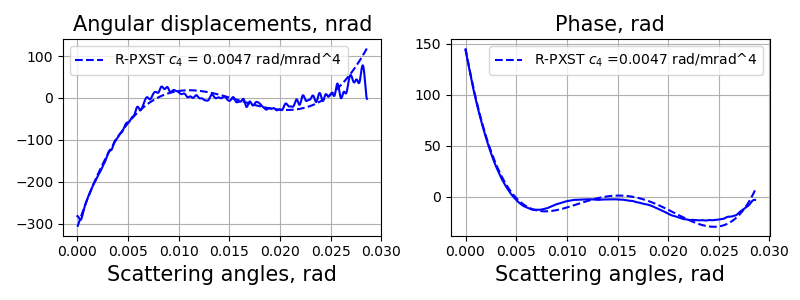

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj.thetas, fit_obj.theta_ab * 1e9, 'b')
axes[0].plot(fit_obj.thetas, fit_obj.model(fit['fit']) * fit_obj.ref_ap * 1e9,
             'b--', label=fr"R-PXST $c_4$ = {fit['c_4']:.4f} rad/mrad^4")
axes[0].set_title('Angular displacements, nrad', fontsize=15)

axes[1].plot(fit_obj.thetas, fit_obj.phase, 'b')
axes[1].plot(fit_obj.thetas, fit_obj.model(fit['ph_fit']), 'b--',
             label=fr"R-PXST $c_4$ ={fit['c_4']:.4f} rad/mrad^4")
axes[1].set_title('Phase, rad', fontsize=15)
for ax in axes:
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=10)
    ax.set_xlabel('Scattering angles, rad', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_fits.png', dpi=300)

In [42]:
out_file = rst.CXIStore('results/sigray.cxi', mode='a')
data = data.update_output_file(out_file)
data.save(mode='overwrite')